In [8]:
Index(3)

(dim=3|id=851)

In [1]:
using ITensors

In [31]:

angle_list = [0,  0.05*pi, 0.10*pi, 0.15*pi, 0.2*pi, 0.25*pi, 0.3*pi, 0.35*pi, 0.4*pi, 0.45*pi, 0.5*pi]

11-element Vector{Float64}:
 0.0
 0.15707963267948966
 0.3141592653589793
 0.47123889803846897
 0.6283185307179586
 0.7853981633974483
 0.9424777960769379
 1.0995574287564276
 1.2566370614359172
 1.413716694115407
 1.5707963267948966

In [71]:

N = 64

# Make an array of N Index objects with alternating
# "S=1/2" and "S=1" tags on odd versus even sites
# (The first argument n->isodd(n) ... is an 
# on-the-fly function mapping integers to strings)

sites = siteinds("S=1/2", N)
entangle_E = []
pa = []
N = 64
i = 2
b = 2
P0_list = []
P1_list = []

ITensors.op(::OpName"P0",::SiteType"S=1/2") =
 [1 0
  0 0]
ITensors.op(::OpName"P1",::SiteType"S=1/2") =
 [0 0
  0 1]

for angle in angle_list
    os = OpSum()
    os -= 4.0*cos(angle)^2, "Sz",1,"Sx",2
    os += 4.0*cos(angle)*sin(angle), "Sz",1,"Sz",2
    os += 4.0*sin(angle)^2, "Sx",1,"Sz",2
    os -= 4.0*cos(angle)*sin(angle), "Sx",1,"Sx",2
    
    os -= 8.0*cos(angle)^3, "Sx", N-2,"Sz",N-1,"Sz",N
    os += 8.0*cos(angle)^2*sin(angle), "Sz",N-2,"Sz",N-1, "Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sx",N-1, "Sz",N
    os -= 8.0*cos(angle)^2*sin(angle), "Sx",N-2,"Sz",N-1, "Sx",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sx",N-1, "Sz",N
    os += 8.0*cos(angle)*sin(angle)^2, "Sz",N-2,"Sz",N-1, "Sx",N
    os -= 8.0*cos(angle)*sin(angle)^2, "Sx",N-2,"Sx",N-1, "Sx",N
    os += 8.0*sin(angle)^3, "Sz",N-2,"Sx",N-1, "Sx",N
    
    os -= 4.0*cos(angle)^2, "Sx", N-1,"Sx",N
    os += 4.0*cos(angle)*sin(angle), "Sx", N-1,"Sz",N
    os -= 4.0*sin(angle)^2, "Sz", N-1,"Sz",N
    os += 4.0*cos(angle)*sin(angle), "Sz", N-1,"Sx",N
    for j=1:N-3
        os -= 8.0*cos(angle)^3, "Sx",j,"Sz",j+1,"Sx",j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sz",j,"Sz",j+1, "Sx", j+2
        os -= 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)^2*sin(angle), "Sx",j,"Sz",j+1,"Sz", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sx",j+1, "Sx", j+2
        os += 8.0*cos(angle)*sin(angle)^2, "Sx",j,"Sx",j+1, "Sz", j+2
        os -= 8.0*cos(angle)*sin(angle)^2, "Sz",j,"Sz",j+1,"Sz", j+2
        os -= 8.0*sin(angle)^3, "Sz",j,"Sx",j+1,"Sz", j+2
    end

    H = MPO(os,sites)

    nsweeps = 5
    maxdim = [10,20,40,80,200]
    cutoff = [1E-10]
    noise = [1E-5, 1E-6, 1E-7, 1E-8, 0.0]
    psi0 = randomMPS(sites,10)

    energy, psi = dmrg(H, psi0; nsweeps, maxdim, cutoff, noise)
    
    for i in 2:12
        # Apply the projection operator to the MPS at site i
        entangle_Ei = 0
        for a in 1:2^(i-1)
            pa_i = 1
            ind = 2
            psi_i = deepcopy(psi)
            combination = digits(a, base = 2, pad = i - 1)
            reverse!(combination)
            for com in combination
                if com == 0
                    new_psi_i = op("P0", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1
                else
                    new_psi_i = op("P1", sites[ind])*psi_i[ind]
                    noprime!(new_psi_i)
                    psi_i[ind] = new_psi_i
                    ind += 1 
                end
            end
            
            pa_i = inner(psi, psi_i)
            
             # Normalize the MPS
            if inner(psi, psi_i) > 1e-32
                normalize!(psi_i)
                orthogonalize!(psi_i, b)
                U,S,V = svd(psi_i[b], (linkind(psi_i, b-1), siteind(psi_i,b)))
                SvN = 0.0
                for n=1:dim(S, 1)
                    p = S[n,n]^2
                    println(p)
                    SvN -= p * log(p+1e-32)
                end
                entangle_Ei += SvN*pa_i
            end
        end
        push!(entangle_E, entangle_Ei)
    end
end


After sweep 1 energy=-63.99914605601135  maxlinkdim=10 maxerr=1.25E-03 time=1.042
After sweep 2 energy=-63.99999995990991  maxlinkdim=6 maxerr=1.00E-10 time=0.324
After sweep 3 energy=-64.00000000000003  maxlinkdim=2 maxerr=1.56E-11 time=0.186
After sweep 4 energy=-63.999999999999964  maxlinkdim=2 maxerr=6.66E-16 time=0.213
After sweep 5 energy=-64.00000000000001  maxlinkdim=2 maxerr=7.77E-16 time=0.817
0.5000000000000093
0.49999999999998845
0.5000000000000092
0.4999999999999888
0.5000000000000092
0.4999999999999888
0.5000000000000092
0.4999999999999888
0.5000000000000103
0.4999999999999886
0.5000000000000204
0.4999999999999798
0.5000000000000009
0.5000000000000007
0.5000000000000197
0.4999999999999801
0.5000000000000013
0.4999999999999999
0.5000000000000204
0.4999999999999798
0.5000000000000013
0.49999999999999944
0.5000000000000211
0.49999999999997996
0.5000000000000022
0.4999999999999993
0.5000000000000208
0.4999999999999798
0.5000000000000219
0.4999999999999795
0.5000000000000013
0

Excessive output truncated after 524298 bytes.


0.9665540688084188
0.03344593119158128
0.9670179863429504

In [33]:
println(entangle_E)

Any[0.5198603854199595, 0.6065037829899527, 0.6498254817749489, 0.6714863311674472, 0.6823167558636963, 0.6877319682118217, 0.6904395743858845, 0.6917933774729158, 0.6924702790164315, 0.692808729788181, 0.5076245140525143, 0.5845956608740619, 0.6160769913181875, 0.6257180461064812, 0.6245992488019428, 0.6184183154977632, 0.6098951911188365, 0.6003278884227201, 0.5904024145932099, 0.58037005018646, 0.47211452110558993, 0.5221399552139518, 0.5235798434760038, 0.5047601347375643, 0.4779305315792785, 0.44877198358325465, 0.420047327239425, 0.3924545101179065, 0.3666170640746943, 0.34235829036260224, 0.4168038103320905, 0.42850274979302677, 0.3950274835009984, 0.3487953981020683, 0.3022129704422828, 0.25980141140694785, 0.2229143984284619, 0.1911015809095677, 0.1638992878495535, 0.140621819360499, 0.3470859456312917, 0.3178632249442632, 0.2588146914077878, 0.20185451173698993, 0.15344267184047888, 0.11605265544152892, 0.0878188454904969, 0.0664667492633538, 0.050369386749390746, 0.038216209

In [85]:
reshaped_array = reshape(log.(abs.(entangle_E)), 11, 11)'


11×11 adjoint(::Matrix{Float64}) with eltype Float64:
  -0.654195   -0.500044   -0.431051  …   -0.36749    -0.367001   -0.366757
  -0.678013   -0.536835   -0.484383      -0.526951   -0.544089   -0.561366
  -0.750534   -0.64982    -0.647066      -1.00344    -1.0719     -1.13997
  -0.87514    -0.847458   -0.9288        -1.8085     -1.96168    -2.11398
  -1.05818    -1.14613    -1.35164       -2.98837    -3.2645     -3.53904
  -1.31048    -1.57439    -1.96073   …   -4.64276    -5.08841    -5.53355
  -1.65078    -2.18095    -2.84305       -6.99934    -7.67952    -8.36817
  -2.11517    -3.05354    -4.15887      -10.5504    -11.6211    -12.6611
  -2.78827    -4.38485    -6.22719      -18.5197    -20.6143    -22.7146
  -3.9579     -6.8048    -10.0077       -31.0534    -36.0501    -34.5633
 -34.1341    -34.3854    -35.415     …  -35.3408    -34.8189    -34.6889

In [89]:
println(reshaped_array[2, :])

[-0.6780132502723396, -0.5368348487169715, -0.4843833373525596, -0.46885541492580374, -0.47064503682049547, -0.480590164589687, -0.4944681544151304, -0.5102792923276604, -0.5269509159460932, -0.5440893613254881, -0.5613661386761438]


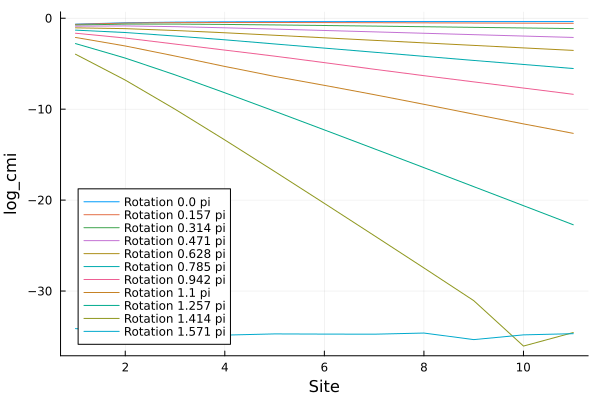

In [74]:
using Plots


# Number of lines (rows of the array)
num_lines = size(reshaped_array, 1)

# Create a plot with multiple lines
p = plot()
for i in 1:num_lines
    angle = round(angle_list[i], digits = 3)
    plot!(1:size(reshaped_array, 2), reshaped_array[i, :], label = "Rotation $angle pi")
end
xlabel!(p, "Site")
ylabel!(p, "log_cmi")
# Display the plot
display(p)


In [70]:
using Pkg
Pkg.add("GLM")

   Resolving package versions...
   Installed StatsFuns ─────────────── v1.3.0
   Installed Rmath_jll ─────────────── v0.4.0+0
   Installed PDMats ────────────────── v0.11.31
   Installed HypergeometricFunctions ─ v0.3.23
   Installed GLM ───────────────────── v1.9.0
   Installed Calculus ──────────────── v0.5.1
   Installed StatsModels ───────────── v0.7.3
   Installed DualNumbers ───────────── v0.6.8
   Installed Rmath ─────────────────── v0.7.1
   Installed OpenSpecFun_jll ───────── v0.5.5+0
   Installed ShiftedArrays ─────────── v2.0.0
   Installed QuadGK ────────────────── v2.9.1
   Installed SpecialFunctions ──────── v2.3.1
   Installed FillArrays ────────────── v1.9.3
   Installed Distributions ─────────── v0.25.104
    Updating `C:\Users\Administrator\.julia\environments\v1.9\Project.toml`
  [38e38edf] + GLM v1.9.0
    Updating `C:\Users\Administrator\.julia\environments\v1.9\Manifest.toml`
  [49dc2e85] + Calculus v0.5.1
  [31c24e10] + Distributions v0.25.104
  [fa6b7ba4] + Dua

In [83]:
println(reshaped_array)

[-0.6541949930334449 -0.5000443132061866 -0.4310514417192354 -0.3982616188962449 -0.38226127754980327 -0.374356098042689 -0.37042681990279847 -0.36846795541746513 -0.3674899602294885 -0.36700132107978234 -0.36675709101387116; -0.6780132502723396 -0.5368348487169715 -0.4843833373525596 -0.46885541492580374 -0.47064503682049547 -0.480590164589687 -0.4944681544151304 -0.5102792923276604 -0.5269509159460932 -0.5440893613254881 -0.5613661386761438; -0.7505336933653614 -0.6498196135988014 -0.6470657417225245 -0.6836719432635511 -0.7382898884764254 -0.8012403518931883 -0.8673878901496878 -0.9353346462651203 -1.0034373978112148 -1.0718974576644538 -1.139973714524838; -0.8751396467131409 -0.8474581237116142 -0.9287999380179401 -1.0532697805490556 -1.1966233100040342 -1.3478377420931547 -1.5009674447659873 -1.6549501550879309 -1.8085031382719743 -1.961681124160134 -2.113984814424079; -1.0581828477688329 -1.1461340989640683 -1.3516429505485694 -1.6002080800033864 -1.874428255065366 -2.15371126464

In [93]:

using GLM

# Example data
x = [1,2,3,4,5,6,7,8,9,10,11]  # Predictor variable
X = hcat(ones(length(x)), x)
slope_list = []
slope_error_list = []
for i in 1:length(angle_list)-1
    y = reshaped_array[i, :]    # Response variable
    model = lm(X, y)

    # Get standard errors of the coefficients
    coefficients = coef(model)
    coeff_errors = stderror(model)
    
    # The standard error of the slope is the second element
    slope = coefficients[2]
    slope_error = coeff_errors[2]
    
    println("Slope: ", slope)
    println("Standard error of the slope: ", slope_error)
    push!(slope_list, slope)
    push!(slope_error_list, slope_error)
end

Slope: 0.020286070069793587
Standard error of the slope: 0.0058135839379222145
Slope: 0.002907671812436001
Standard error of the slope: 0.005959471240601643
Slope: -0.04851863507274976
Standard error of the slope: 0.006262911482306906
Slope: -0.1345266574995507
Standard error of the slope: 0.006560667455971392
Slope: -0.25970580594515486
Standard error of the slope: 0.006751886011852888
Slope: -0.4342059602464314
Standard error of the slope: 0.006598591954030568
Slope: -0.6828697346489571
Standard error of the slope: 0.005774661209660949
Slope: -1.0591581121065976
Standard error of the slope: 0.004566880999911794
Slope: -2.0182926278329214
Standard error of the slope: 0.01956677708477406
Slope: -3.3485577081322733
Standard error of the slope: 0.11308197652843939


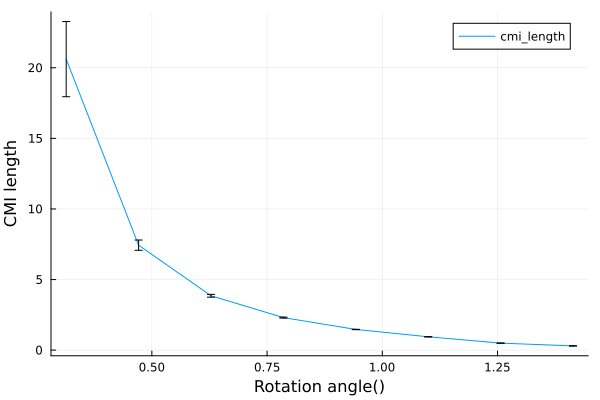

In [103]:
p = plot(angle_list[3:end-1], -1 ./ slope_list[3:end], yerr = (1 ./ slope_list[3:end]).^2 .* slope_error_list[3:end], label = "cmi_length")
xlabel!(p, "Rotation angle()")
ylabel!(p, "CMI length")

In [53]:
println(1e-32)

1.0e-32


In [116]:
N = 10
s = siteinds(2,N)
chi = 4
psi = randomMPS(s;linkdims=chi)

# Make an array of integers of the element we
# want to obtain
el = [1,2,1,1,2,1,2,2,2,1]

V = ITensor(1.)
for j=1:N
  V *= (psi[j]*state(s[j],el[j]))
end
v = scalar(V)

# v is the element we wanted to obtain:
@show v

v = 0.0026343181003195197


0.0026343181003195197